In [1]:
import sys
sys.path.append("../src")

import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from utils import get_dataset, Encoder

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cache_dir = os.path.join("..", "data")
split = "train"

train_dataset = get_dataset(cache_dir=cache_dir, split=split)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [3]:
batch = next(iter(train_loader))

batch.keys()

dict_keys(['image', 'label'])

In [4]:
batch["image"].keys()

dict_keys(['global_crops', 'local_crops'])

In [5]:
views = batch["image"]

global_crops = views["global_crops"]
local_crops = views["local_crops"]

In [6]:
global_crop0 = global_crops[0]
global_crop1 = global_crops[1]

local_crop0 = local_crops[0]
local_crop1 = local_crops[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


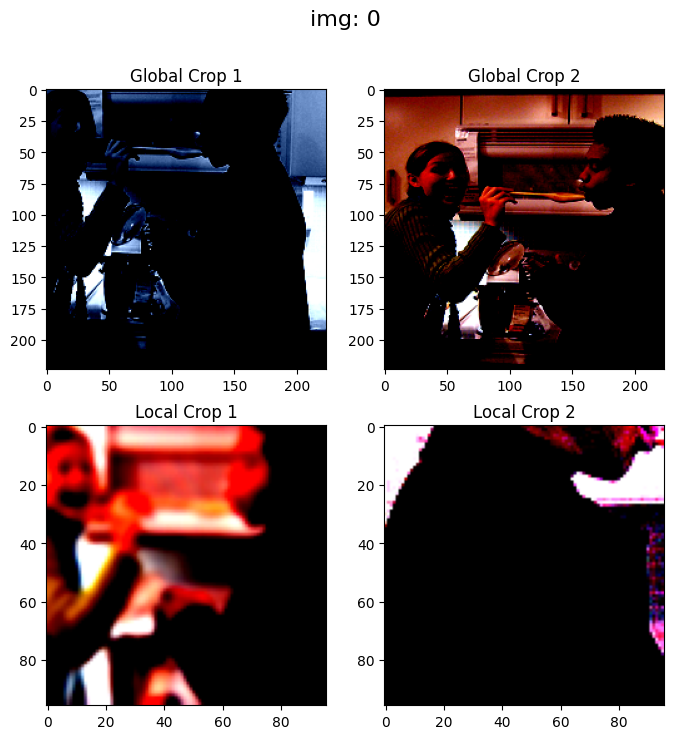

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


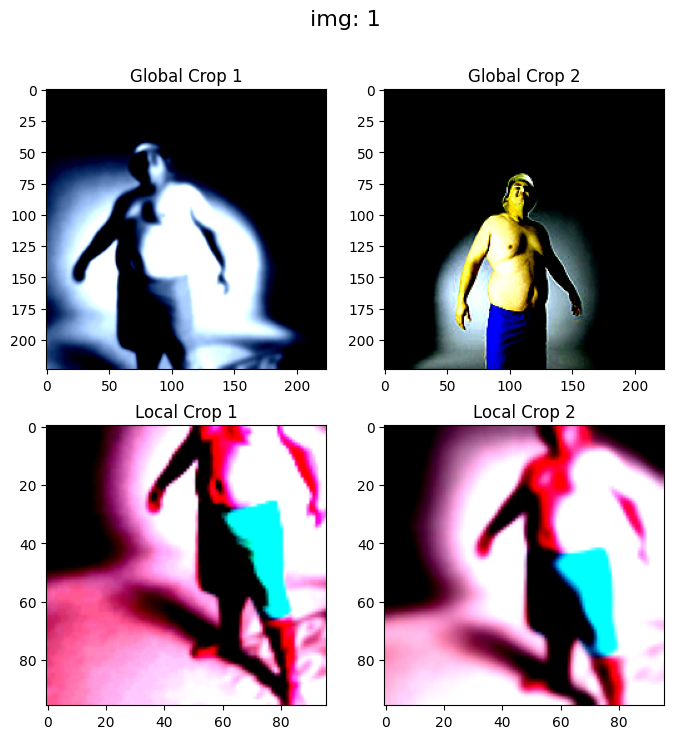

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


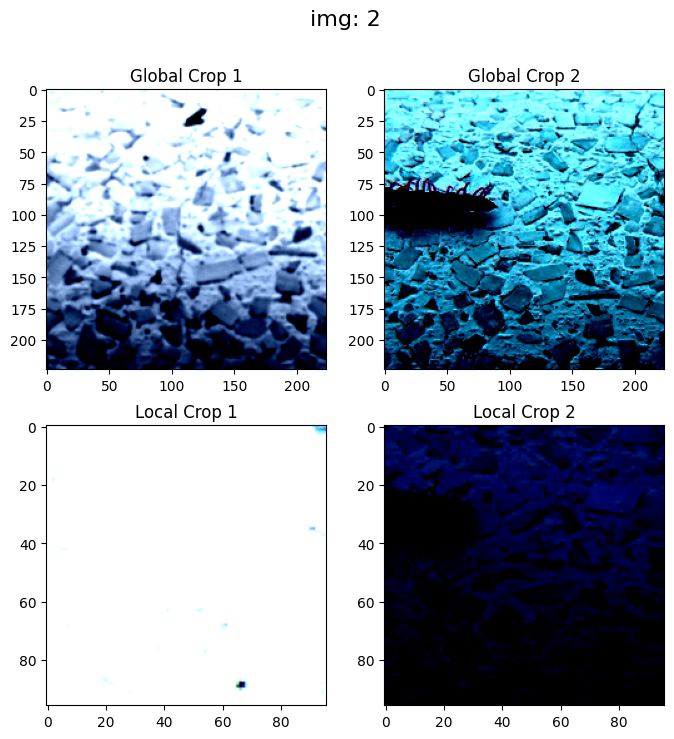

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


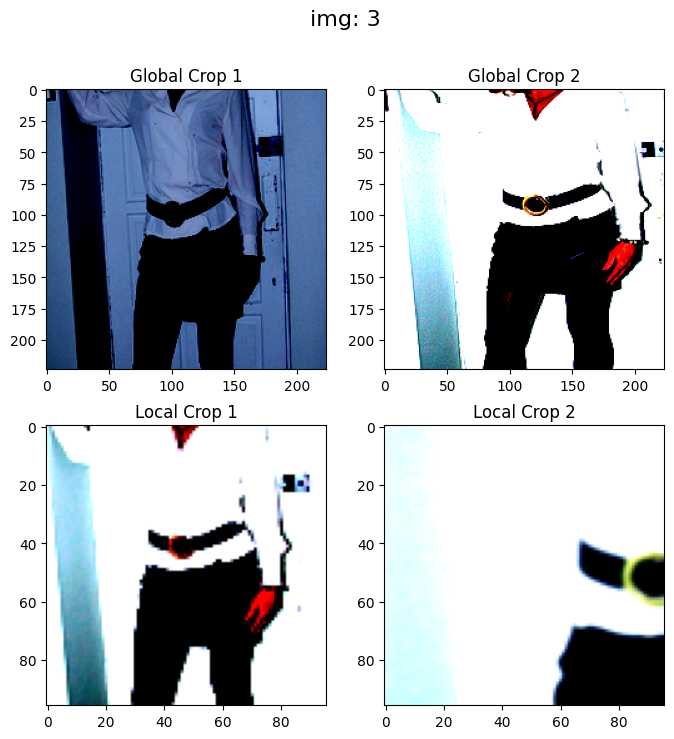

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


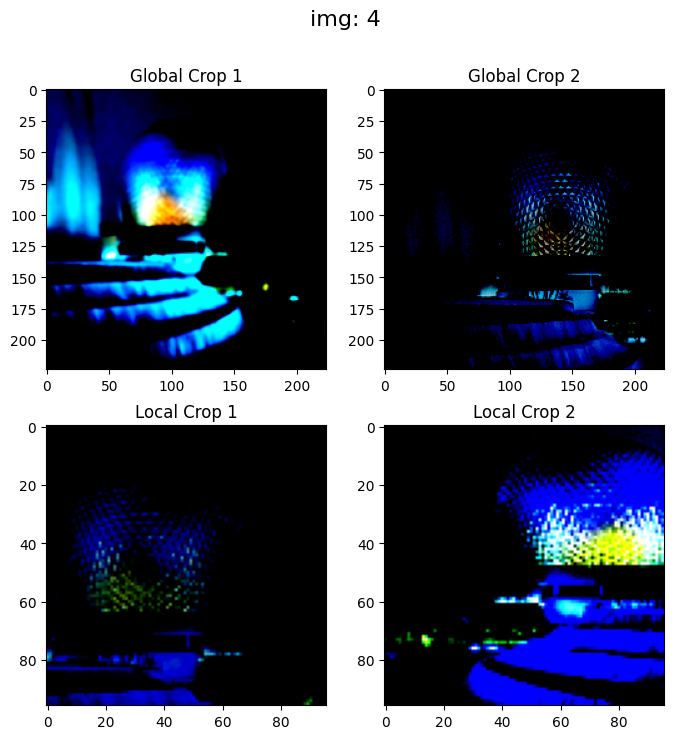

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


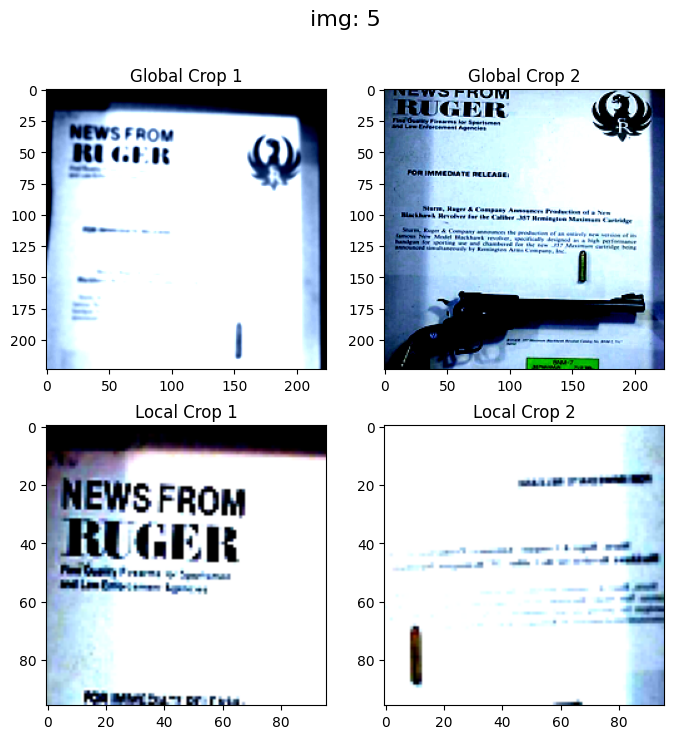

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


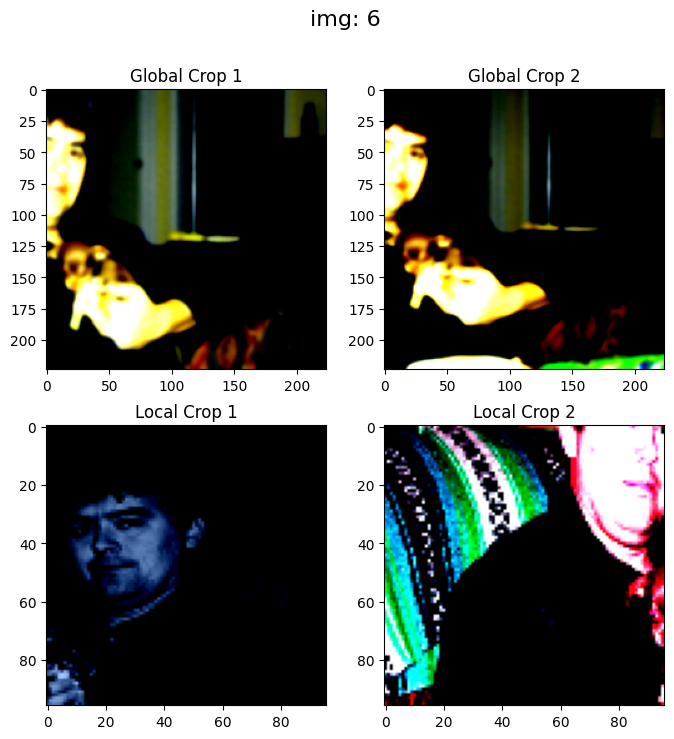

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


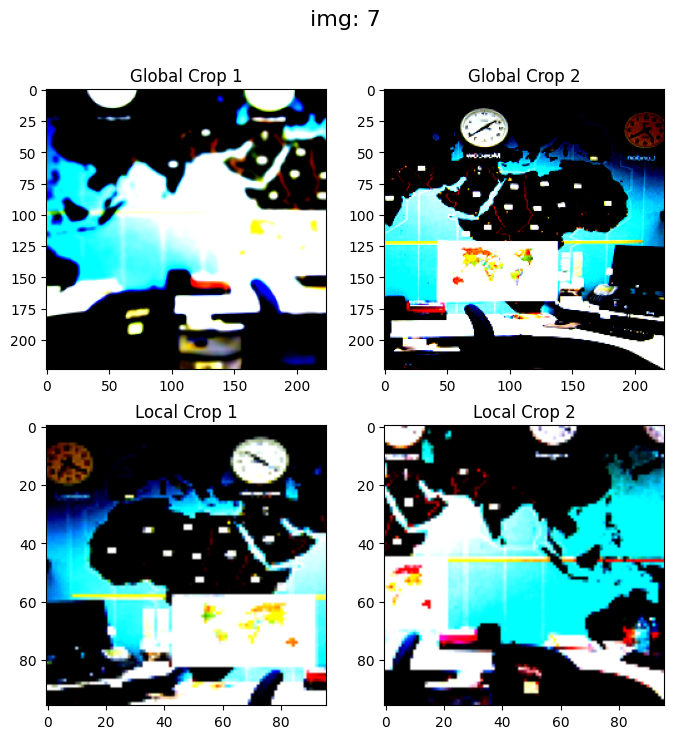

In [7]:
for idx in range(len(global_crop0)):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(f"img: {idx}", fontsize=16)

    axes[0][0].imshow(global_crop0[idx].permute(1,2,0).numpy())
    axes[0][0].set_title("Global Crop 1")

    axes[0][1].imshow(global_crop1[idx].permute(1,2,0).numpy())
    axes[0][1].set_title("Global Crop 2")

    axes[1][0].imshow(local_crop0[idx].permute(1,2,0).numpy())
    axes[1][0].set_title("Local Crop 1")

    axes[1][1].imshow(local_crop1[idx].permute(1,2,0).numpy())
    axes[1][1].set_title("Local Crop 2")

    plt.show()

In [8]:
def center_outputs(
    teacher_out: torch.Tensor,
    center: torch.Tensor,
    momentum: float
    ) -> torch.Tensor:
    
    center = momentum * center + (1 - momentum) * torch.mean(teacher_out, dim=0, keepdim=True)
    
    teacher_out = teacher_out - center
    
    return teacher_out

In [56]:
teacher = Encoder("vit-s-16")
for param in teacher.parameters():
    param.requires_grad = False

student = Encoder("vit-s-16")

In [57]:
@torch.no_grad()
def update_teacher(teacher, student, momentum):
    for param_t, param_s in zip(teacher.parameters(), student.parameters()):
        param_t.data.mul_(momentum).add_((1 - momentum) * param_s.data)

In [58]:
for param in teacher.parameters():
    print(param)

Parameter containing:
tensor([[[-1.3782e-07,  2.3344e-07, -1.3561e-07,  1.2809e-06,  5.7415e-07,
          -1.0048e-06,  1.0293e-06, -5.4825e-07,  2.2544e-07, -1.7080e-07,
           3.8289e-07, -1.1981e-06,  2.4526e-07,  1.4505e-07,  9.5916e-09,
          -8.8025e-07, -1.2888e-06,  8.3950e-07, -7.0950e-07, -1.4675e-06,
           7.8416e-07, -4.5461e-07, -2.0173e-06,  2.8939e-07, -3.0676e-07,
          -7.3462e-07, -8.6293e-08,  1.2942e-07, -1.5730e-06, -2.0093e-06,
          -6.2108e-07,  1.3012e-06, -6.1963e-07, -6.7751e-07,  5.2771e-07,
           1.4383e-06,  2.5982e-07,  1.3567e-07,  7.6694e-07,  1.6581e-06,
           8.9731e-08,  8.9864e-07,  4.7361e-08, -2.8245e-07, -4.9384e-07,
           3.0053e-07, -6.8268e-07, -3.8405e-07,  4.3182e-07,  1.9828e-07,
           1.5532e-06, -1.6833e-07,  1.3363e-07, -3.0160e-08,  1.0135e-06,
           4.6033e-07,  3.6996e-07,  2.7269e-07, -9.2763e-07, -7.0347e-07,
           3.4891e-07, -1.8024e-07, -8.4354e-07,  1.0553e-06, -8.7257e-08,
   

In [59]:
def get_param_groups(encoder):
    regularized = []
    not_regularized = []

    for name, param in encoder.named_parameters():
        if param.requires_grad:
            if name.endswith(".bias") or len(param.shape) == 1:
                not_regularized.append(param)

            else:
                regularized.append(param)

    param_groups = [
        {"params": regularized},
        {"params": not_regularized, "weight_decay": 0.0}
    ]

    return param_groups

In [60]:
param_groups = get_param_groups(student)

# param_groups

In [61]:
optimizer = torch.optim.AdamW(param_groups)

len(optimizer.param_groups)

2

In [62]:
# update_teacher(teacher, student, momentum=1)

# for param in teacher.parameters():
#     print(param)

In [63]:
with torch.inference_mode():
    teacher_outs = {
        "g0": teacher(global_crop0),
        "g1": teacher(global_crop1)
    }

student_outs = {
    "g0": student(global_crop0),
    "g1": student(global_crop1)
}
for i, crop in enumerate(local_crops):
    student_out = student(crop)
    student_outs[f"l{i}"] = student_out

In [65]:
print("g0 shape:", teacher_outs["g0"].shape)
print("g1 shape:", teacher_outs["g1"].shape)

g0 shape: torch.Size([8, 65536])
g1 shape: torch.Size([8, 65536])


In [67]:
torch.cat([v for _, v in teacher_outs.items()], dim=0).shape

torch.Size([16, 65536])

In [122]:
center = 0
centered = center_outputs(teacher_out, center, momentum=0.9)

centered.shape

center shape: torch.Size([1, 65536])


torch.Size([8, 65536])

In [143]:
epochs = 1
num_warmup_epochs = 1
teacher_temp = (0.04, 0.07)

temperatures = np.concatenate([
    np.linspace(
        start=teacher_temp[0], 
        stop=teacher_temp[1],
        num=num_warmup_epochs
    ), np.ones(epochs - num_warmup_epochs) * teacher_temp[1]
    ])

len(temperatures)

1

In [145]:
student_temp = 0.1

for epoch in range(0, epochs):
    teacher_temp = temperatures[epoch]

    total_loss = 0 # accumulated loss across view types
    n_loss_terms = 0

    for global_crop, teacher_out in teacher_outs.items():
        teacher_out = F.softmax((teacher_out / teacher_temp), dim=-1)
        print("teacher_crop:", global_crop)

        for crop, student_out in student_outs.items():
            if global_crop != crop:
                student_out = F.softmax((student_out / student_temp), dim=-1)

                loss = -torch.sum(teacher_out * torch.log(student_out), dim=-1)
                avg_loss = loss.mean()
                total_loss += avg_loss
                n_loss_terms += 1

                print("student_crop:", crop)
                print("avg_loss:", avg_loss)
                print()

    iteration_loss = total_loss / n_loss_terms

    print("total loss:", total_loss)
    print("n loss terms:", n_loss_terms)
    print("iteration loss:", iteration_loss)

teacher_crop: g0
student_crop: g1
avg_loss: tensor(11.0989, grad_fn=<MeanBackward0>)

student_crop: l0
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

student_crop: l1
avg_loss: tensor(11.0989, grad_fn=<MeanBackward0>)

teacher_crop: g1
student_crop: g0
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

student_crop: l0
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

student_crop: l1
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

total loss: tensor(66.5939, grad_fn=<AddBackward0>)
n loss terms: 6
iteration loss: tensor(11.0990, grad_fn=<DivBackward0>)


to-do:
- LR warm up
- ema weight update for teacher
- temperature schedule
- weight decay schedule
- centering
- sharpening (confirm completion from temperature)

## Training Hyperparameters

In [78]:
%%latex
\begin{gather}
    T_s = 0.1 \\
    T_t = 0.07, \text{(Linear warm-up from 0.04 for the first 30 epochs)} \\
    lr = 0.0005 * \frac{batchsize}{256}, \text{(cosine schedule)} \\
    weight\_decay = 0.04 \ \text{to}\  0.4, \text{(cosine schedule)}
\end{gather}

<IPython.core.display.Latex object>

## Update Rules

In [90]:
%%latex
\begin{gather}
    \theta_{t} \leftarrow \lambda\theta_{t} + (1 - \lambda)\theta_{s}, \ \text{(teacher param update)} \\
    \lambda = 0.996 \ \text{to} \ 1, \ \text{(cosine schedule)} \\
    c \leftarrow mc + (1 - m) \frac{1}{B}\sum_{i=1}^{B}g\theta_{t}(x_i), \ \text{(centering update)} \\
    m = 0.9
\end{gather}

<IPython.core.display.Latex object>

In [91]:
teacher_out.shape

torch.Size([8, 65536])